In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import albumentations as A
import cv2
import numpy as np
import skimage as ski

import matplotlib.pyplot as plt
import os
import copy

from tqdm import tqdm
from IPython.display import clear_output

import psutil
import pynvml
import sys

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


sys.path.append('/home/meribejayson/Desktop/Projects/SharkCNN/training_models/dataloaders/')

from test_dataset import SharkDatasetTest as SharkDataset

In [2]:
lr_model_path = "/home/meribejayson/Desktop/Projects/SharkCNN/training_models/LOGISTIC-REG/train-final-3/lr_weights_train_3.tar"
ann_model_path = "/home/meribejayson/Desktop/Projects/SharkCNN/training_models/ANN/train-1/ann_weights_train_1.tar"

state_dict_lr = torch.load(lr_model_path)
state_dict_ann = torch.load(ann_model_path)

torch.manual_seed(12)

if not torch.cuda.is_available():
    raise Exception("Couldn't find CUDA")

device = torch.device("cuda")

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)


image_width = 1920
image_height = 1080

In [3]:
# class ANN(nn.Module):

#     def __init__(self, input_size):
#         super().__init__()
        
#         hidden_layer_num = int(input_size / 2)

#         self.linear1 = nn.Linear(input_size, hidden_layer_num)
#         self.relu1 = nn.ReLU()
#         self.linear2 = nn.Linear(hidden_layer_num, hidden_layer_num)
#         self.relu2 = nn.ReLU()
#         self.linear3 = nn.Linear(hidden_layer_num + input_size, 1)
#         self.sig = nn.Sigmoid()
        

#     def forward(self, x):
#         h = self.linear1(x)
#         h = self.relu1(h)
#         h = self.linear2(h)
#         h = self.relu2(h)
#         h = torch.cat((x, h), dim=1)
#         h = self.linear3(h)
        
#         return self.sig(h)

In [4]:
class ANN(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        
        hidden_layer_num = int(input_size / 2)

        self.linear1 = nn.Linear(input_size, hidden_layer_num)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_num + input_size, 1)
        self.sig = nn.Sigmoid()
        

    def forward(self, x):
        h = self.linear1(x)
        h = self.relu1(h)
        h = torch.cat((x, h), dim=1)
        h = self.linear2(h)
        
        return self.sig(h)

In [5]:
class LogisticRegresion(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        
        self.linear = nn.Linear(input_size,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        
        return self.sig(x)

In [6]:
test_dataset = SharkDataset()

test_data_loader = data.DataLoader(test_dataset, batch_size=500_000, num_workers=1)

In [7]:
ann_state = torch.load("/home/meribejayson/Desktop/Projects/SharkCNN/training_models/ANN/train-4/ann_weights_train_4.tar")
lr_state = torch.load("/home/meribejayson/Desktop/Projects/SharkCNN/training_models/LOGISTIC-REG/train-final-6/lr_weights_train_6.tar")

ann_model = ANN(85)
ann_model.load_state_dict(ann_state)
ann_model.to(device)


lr_model = LogisticRegresion(85)
lr_model.load_state_dict(lr_state)
lr_model.to(device)


LogisticRegresion(
  (linear): Linear(in_features=85, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [8]:
def calculate_metrics(preds, data_labels):
    conf_thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] 
    precision_varying = []
    recall_varying = []
    f1_score_varying = []

    for thresh in conf_thresholds:
        TP = preds[(preds > thresh) & (data_labels == 1.0)].size(dim=0)
        FP = preds[(preds > thresh) & (data_labels == 0.0)].size(dim=0)
        FN = preds[(preds < thresh) & (data_labels == 1.0)].size(dim=0)

        if(TP + FN + FP == 0):
            return None

        curr_thresh_precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        curr_thresh_recall = TP / (TP + FN) if (TP + FN) != 0 else 0

        curr_thresh_f1_score = (2 * curr_thresh_precision * curr_thresh_recall) / (curr_thresh_recall + curr_thresh_precision) if (curr_thresh_recall + curr_thresh_precision) != 0 else 0


        precision_varying.append(curr_thresh_precision)
        recall_varying.append(curr_thresh_recall)
        f1_score_varying.append(curr_thresh_f1_score)

    MAP_50 = precision_varying[0]
    MAP50_95 = np.mean(np.array(precision_varying))

    best_f1_score_idx = np.argmax(np.array(curr_thresh_f1_score))
    
    f1_score = f1_score_varying[best_f1_score_idx]
    recall = recall_varying[best_f1_score_idx]
    precision = precision_varying[best_f1_score_idx]

    return {
        "MAP50": MAP_50,
        "MAP50_95": MAP50_95,
        "F1_Score": f1_score,
        "Recall": recall,
        "Precision": precision
    } 

In [9]:
def eval_model(data_loader):
    ann_model.eval()
    lr_model.eval()

    curr_iter = 1
    
    # Logisitic Regression Stats
    precision_lr = np.array([])
    recall_lr = np.array([])
    pr_thresh_lr = np.array([]) 

    tpr_lr = np.array([])
    fpr_lr = np.array([])
    tp_thresh_lr = np.array([])

    f1_score_lr = np.array([])
    f1_thresh_lr = np.array([])

    map_50_lr = np.array([])
    map_50_95_lr = np.array([])

    # ANN Stats 
    precision_ann = np.array([])
    recall_ann = np.array([])
    pr_thresh_ann = np.array([]) 

    tpr_ann = np.array([])
    fpr_ann = np.array([])
    tp_thresh_ann = np.array([])

    f1_score_ann = np.array([])
    f1_thresh_ann = np.array([])

    map_50_ann = np.array([])
    map_50_95_ann = np.array([])
    
    confs = [0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    
    # Beware inefficient code lays ahead
    while(curr_iter < 300):
        with torch.no_grad():
            for point in data_loader:
                data_inputs = point[:, :-1].to(device).float()
                data_labels = point[:, -1].to(device).float()

                labels = data_labels.to('cpu').numpy().astype(int).flatten()
                
                ann_preds = ann_model(data_inputs).to('cpu').numpy().flatten()
                lr_preds = lr_model(data_inputs).to('cpu').numpy().flatten()

                # Precision Recall
                curr_precision_ann, curr_recall_ann, curr_pr_thresh_ann = precision_recall_curve(labels, ann_preds)
                curr_precision_lr, curr_recall_lr, curr_pr_thresh_lr = precision_recall_curve(labels, lr_preds)

                precision_ann = np.append(precision_ann, curr_precision_ann)
                precision_lr = np.append(precision_lr, curr_precision_lr)

                recall_ann = np.append(recall_ann, curr_recall_ann)
                recall_lr = np.append(recall_lr, curr_recall_lr)

                pr_thresh_ann = np.concatenate((pr_thresh_ann, curr_pr_thresh_ann, np.array([1])))
                pr_thresh_lr = np.concatenate((pr_thresh_lr, curr_pr_thresh_lr, np.array([1])))

                # ROC
                curr_fpr_ann, curr_tpr_ann, curr_tp_thresh_ann = roc_curve(labels, ann_preds)
                curr_fpr_lr, curr_tpr_lr, curr_tp_thresh_lr = roc_curve(labels, lr_preds)

                fpr_ann = np.append(fpr_ann, curr_fpr_ann)
                tpr_ann = np.append(tpr_ann, curr_tpr_ann)
                tp_thresh_ann = np.append(tp_thresh_ann, curr_tp_thresh_ann)

                fpr_lr = np.append(fpr_lr, curr_fpr_lr)
                tpr_lr = np.append(tpr_lr, curr_tpr_lr)
                tp_thresh_lr = np.append(tp_thresh_lr, curr_tp_thresh_lr)

                # F1 Score
                f1_score_lr = np.append(f1_score_lr, (2 * precision_lr * recall_lr) / (precision_lr + recall_lr))
                f1_thresh_lr = np.append(f1_thresh_lr, pr_thresh_lr)

                f1_score_ann = np.append(f1_score_ann, (2 * precision_ann * recall_ann) / (precision_ann + recall_ann))
                f1_thresh_ann = np.append(f1_thresh_ann, pr_thresh_ann)

                f1_score_lr[np.isnan(f1_score_lr)] = 0
                f1_score_ann[np.isnan(f1_score_ann)] = 0

                # MAP 50
                map_50_lr = np.append(map_50_lr, np.mean(precision_lr[pr_thresh_lr > 0.5]))
                map_50_ann = np.append(map_50_ann, np.mean(precision_ann[pr_thresh_ann > 0.5]))

                # MAP 50-95
                map_temp_lr = 0

                for conf in confs:
                    map_temp_lr += np.mean(precision_lr[pr_thresh_lr > conf])


                map_50_95_lr = np.append(map_50_lr, np.mean(map_temp_lr))


                map_temp_ann = 0

                for conf in confs:
                    map_temp_ann += np.mean(precision_ann[pr_thresh_ann > conf])


                map_50_95_ann = np.append(map_50_ann, map_temp_ann)


                MAP_50_ANN = np.mean(map_50_ann)
                MAP_50_95_ANN = np.mean(map_50_95_ann)
                f1_score_ANN = np.mean(f1_score_ann)
                recall_ANN = np.mean(recall_ann)
                precision_ANN = np.mean(precision_ann)

                MAP_50_LR = np.mean(map_50_lr)
                MAP_50_95_LR = np.mean(map_50_95_lr)
                f1_score_LR = np.mean(f1_score_lr)
                recall_LR = np.mean(recall_lr)
                precision_LR = np.mean(precision_lr)

                clear_output(wait=True)
                info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                print(f'Current iteration: {curr_iter}')
                print('='*60)
                print("ANN Metrics")
                print(f"MAP50: {MAP_50_ANN} MAP50-95: {MAP_50_95_ANN} Precision: {precision_ANN} Recall: {recall_ANN} F1 score: {f1_score_ANN}")
                print("\n")
                print("LR Metrics")
                print(f"MAP50: {MAP_50_LR} MAP50-95: {MAP_50_95_LR} Precision: {precision_LR} Recall: {recall_LR} F1 score: {f1_score_LR}")
                print('='*60)
                print(f"CPU Usage: {psutil.cpu_percent()}% GPU memory usage: {int(info.used / info.total)}% \n")

            roc_plot_ann = RocCurveDisplay(fpr=fpr_ann, tpr=tpr_ann)
            roc_plot_ann.plot()
            plt.title('ROC ANN')
            plt.show()
            plt.clf()

            roc_plot_lr = RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr)
            roc_plot_lr.plot()
            plt.title('ROC LR')
            plt.show()
            plt.clf()

            pr_plot_ann = PrecisionRecallDisplay(precision=precision_ann, recall=recall_ann)
            pr_plot_ann.plot()
            plt.title('Precision-Recall ANN')
            plt.show()
            plt.clf()

            pr_plot_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
            pr_plot_lr.plot()
            plt.title('Precision-Recall LR')
            plt.show()
            plt.clf()

            plt.figure(figsize=(12, 8))
            plt.plot(f1_thresh_ann, f1_thresh_ann, color='blue')


            plt.xlabel('Confidence')
            plt.ylabel('F1-Score')
            plt.title('F1-Score ANN')
            plt.show()
            
            plt.clf()

            plt.figure(figsize=(12, 8))
            plt.plot(f1_thresh_lr, f1_thresh_lr, color='blue')


            plt.xlabel('Confidence')
            plt.ylabel('F1-Score')
            plt.title('F1-Score LR')
            plt.show()

            plt.clf()

        curr_iter += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Current iteration: 2
ANN Metrics
MAP50: 0.008428622118494768 MAP50-95: 0.018572283780258256 Precision: 0.000730231067150756 Recall: 0.506992363730339 F1 score: 0.001386628653637589


LR Metrics
MAP50: 0.0014307817241454395 MAP50-95: 0.004466507552530779 Precision: 0.0006155106479864091 Recall: 0.4679663814537952 F1 score: 0.0012035567772632472
CPU Usage: 4.4% GPU memory usage: 0% 



<Figure size 640x480 with 0 Axes>

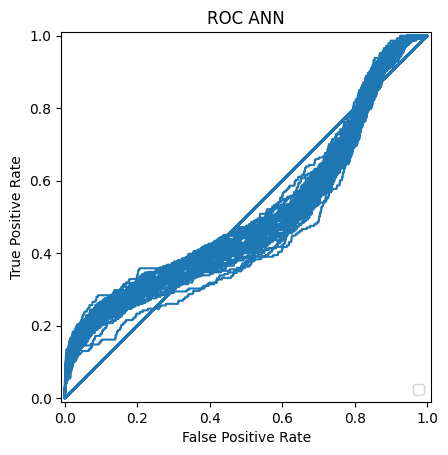

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

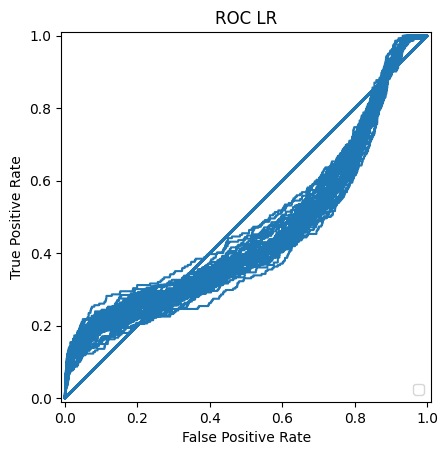

<Figure size 640x480 with 0 Axes>

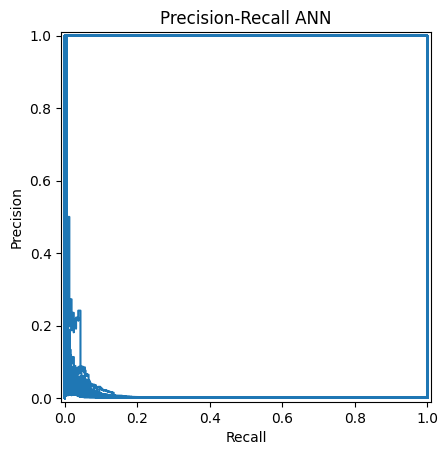

<Figure size 640x480 with 0 Axes>

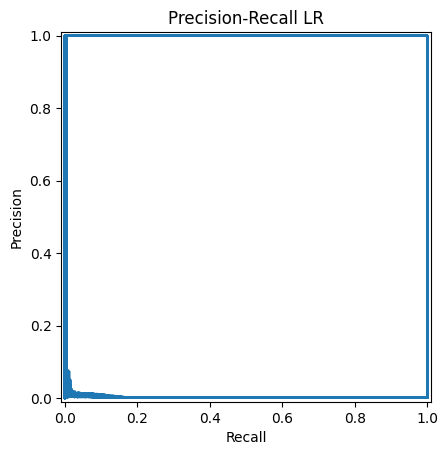

<Figure size 640x480 with 0 Axes>

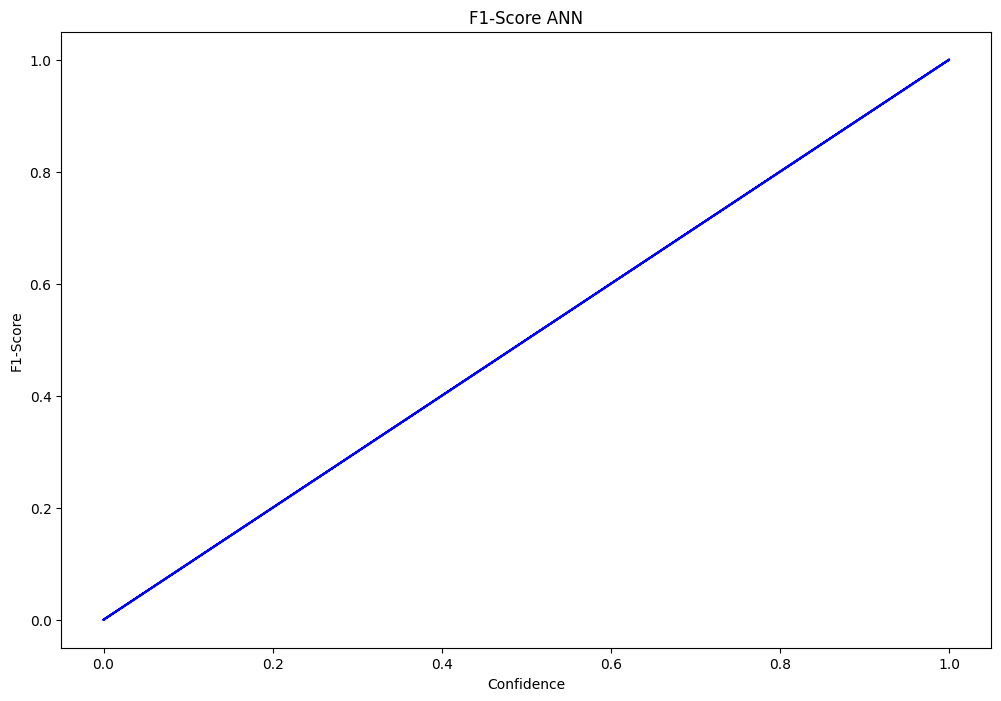

<Figure size 640x480 with 0 Axes>

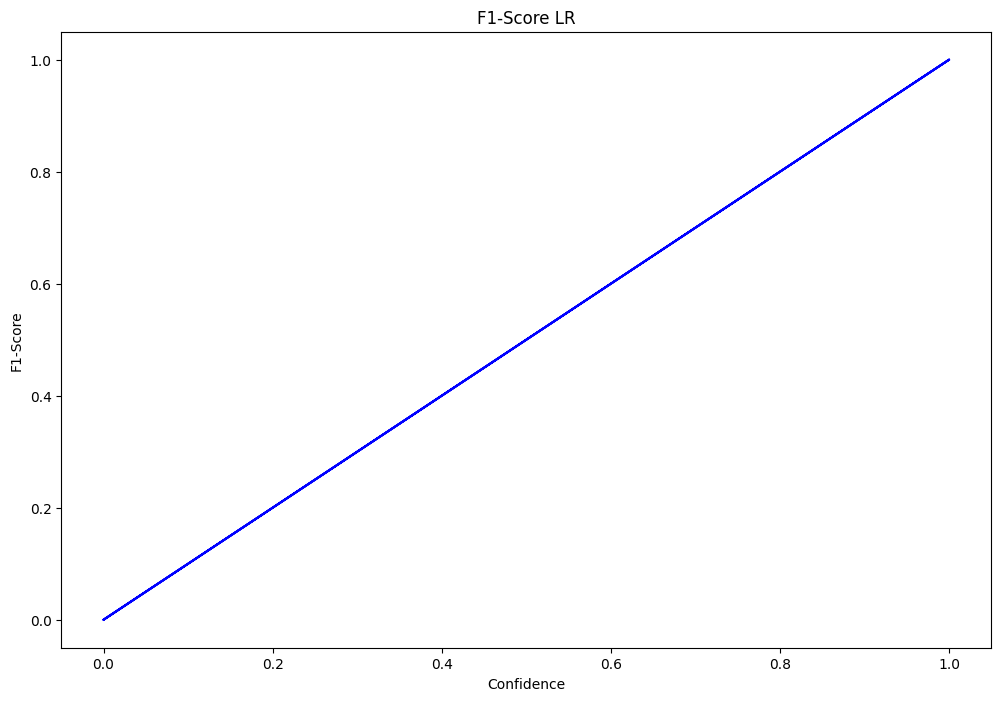

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [10]:
eval_model(test_data_loader)